In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import VOCSegmentation
import torchvision.transforms as T
from PIL import Image



In [2]:
#train_dataset = VOCSegmentation(root='data/', year='2012', image_set='train', download=True)

# writing custom dataset, inheriting from VOCSegmentation dataset
class VOCSegmentationWithPIL(VOCSegmentation):
    def __init__(self, root='data', year='2012', image_set='train',
                 download=True, image_size=(224, 224)):
        super().__init__(root=root, year=year, image_set=image_set, download=download)
        self.image_resize = T.Resize(image_size)
        self.mask_transform = T.Compose([
            T.Resize(image_size, interpolation=Image.NEAREST),
            T.PILToTensor(),  # Keeps label values intact
        ])

    def __getitem__(self, index):
        image, mask = super().__getitem__(index)
        image = self.image_resize(image)  # still PIL.Image
        mask = self.mask_transform(mask).squeeze(0).long()  # [H, W] as LongTensor
        return image, mask

In [3]:
def collate_fn_pil(batch):
    images, masks = zip(*batch)  # tuple of lists
    return list(images), torch.stack(masks)  # keep images as list of PIL


In [5]:
train_dataset = VOCSegmentationWithPIL(
    root='src/data_train',
    year='2012',
    image_set='train',
    download=True,
    image_size=(224, 224)
)

train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn_pil,
    pin_memory=True
)

Using downloaded and verified file: src/data_train/VOCtrainval_11-May-2012.tar
Extracting src/data_train/VOCtrainval_11-May-2012.tar to src/data_train


In [6]:
len(train_dataset)

1464

In [7]:
val_dataset = VOCSegmentationWithPIL(
    root='src/data_val',
    year='2012',
    image_set='val',
    download=True,
    image_size=(224, 224)
)

val_loader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn_pil,
    pin_memory=True
)

Using downloaded and verified file: src/data_val/VOCtrainval_11-May-2012.tar
Extracting src/data_val/VOCtrainval_11-May-2012.tar to src/data_val


In [8]:
len(val_dataset)

1449

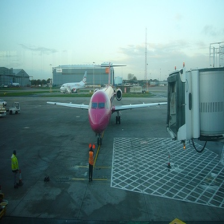

In [9]:
imgs = train_dataset[0]
imgs[0]

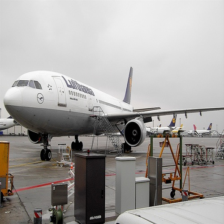

In [10]:
imgs = val_dataset[0]
imgs[0]

In [11]:
for imgs, masks in train_loader:
    print(len(imgs), len(masks)) # now images in batch are PIL and masks in batch are Tensor
    print(imgs[0], masks[0])
    break

8 8
<PIL.Image.Image image mode=RGB size=224x224 at 0x79C9E0EDCF50> tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])


In [12]:
for imgs, masks in val_loader:
    print(len(imgs), len(masks)) # now images in batch are PIL and masks in batch are Tensor
    print(imgs[0], masks[0])
    break

8 8
<PIL.Image.Image image mode=RGB size=224x224 at 0x79C9E0EDF010> tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])


In [ ]:
# from torchvision import transforms
# def resize_image(img):
#     """Resize the input image using torchvision transforms
#     """
#     # here my image is already in PIL format so NO need to do the below code.
#     #to_pil_image = transforms.ToPILImage()
#     resize_transform = transforms.Resize(size=(224, 224))

#     # return resize_transform(to_pil_image(img))
#     return resize_transform(img)

In [13]:
import torch
from transformers import AutoImageProcessor, Dinov2Model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

image_processor = AutoImageProcessor.from_pretrained("facebook/dinov2-large")
dino_model = Dinov2Model.from_pretrained("facebook/dinov2-large").to(device)

for images, masks in train_loader:
    # images: list of 8 PIL images
    # masks: [B, H, W] tensor

    inputs = image_processor(images, return_tensors='pt').to(device)
    dino_feats = dino_model(inputs.pixel_values).last_hidden_state  # [B, 257, 1024]

    # skip [CLS] token
    dino_feats = dino_feats[:, 1:, :]  # [B, 256, 1024]
    dino_feats = dino_feats.reshape(-1, 16, 16, 1024).permute(0, 3, 1, 2)  # [B, 1024, 16, 16]

    # ... pass dino_feats into your segmentation head ...
    break  # just test 1 batch

# torch.unique(masks[3])
dino_feats.shape, masks.shape

(torch.Size([8, 1024, 16, 16]), torch.Size([8, 224, 224]))

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class UNetDecoder(nn.Module):
    def __init__(self, in_channels=1024, num_classes=21):
        super().__init__()

        # Upsample from 16x16 → 32x32 → 64x64 → 128x128 → 224x224 (final)
        self.up1 = self._upsample_block(in_channels, 512)
        self.up2 = self._upsample_block(512, 256)
        self.up3 = self._upsample_block(256, 128)
        self.up4 = self._upsample_block(128, 64)

        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def _upsample_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up1(x)  # 16 → 32
        x = self.up2(x)  # 32 → 64
        x = self.up3(x)  # 64 → 128
        x = self.up4(x)  # 128 → ~256
        x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)  # match input size
        x = self.final_conv(x)
        return x  # [B, num_classes, 224, 224]


In [15]:
class DinoSegModel(nn.Module):
    def __init__(self, freeze_dino=True, num_classes=21):
        super().__init__()
        self.dino = Dinov2Model.from_pretrained("facebook/dinov2-large")
        self.decoder = UNetDecoder(in_channels=1024, num_classes=num_classes)

        if freeze_dino:
            for param in self.dino.parameters():
                param.requires_grad = False

    def forward(self, pixel_values):  # [B, 3, 224, 224]
        feats = self.dino(pixel_values).last_hidden_state  # [B, 257, 1024]
        feats = feats[:, 1:, :]  # remove CLS token
        feats = feats.reshape(-1, 16, 16, 1024).permute(0, 3, 1, 2)  # [B, 1024, 16, 16]
        seg_logits = self.decoder(feats)  # [B, num_classes, 224, 224]
        return seg_logits


In [ ]:
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm  # progress bar

# Model Setup
image_processor = AutoImageProcessor.from_pretrained("facebook/dinov2-large")
model = DinoSegModel(freeze_dino=True).to(device)  # freeze_dino=False for fine-tuning

# Criterion and Optimizer
criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

num_epochs = 100
train_losses = []
val_losses = []

model.train()

def evaluate(model, val_loader, criterion, image_processor, device, epoch):
    model.eval()
    val_loss = 0.0
    
    val_loop = tqdm(val_loader, desc=f"Validation Epoch {epoch+1}")

    with torch.no_grad():
        for step, (images, masks) in enumerate(val_loop):
            inputs = image_processor(images, return_tensors='pt').to(device)
            masks = masks.to(device)

            outputs = model(inputs.pixel_values)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            if step == 0:
                # Show predictions on first batch
                preds = outputs.argmax(dim=1)
                plt.figure(figsize=(10, 4))
                plt.subplot(1, 3, 1)
                plt.imshow(images[0])
                plt.title("Input Image")
                plt.axis("off")

                plt.subplot(1, 3, 2)
                plt.imshow(masks[0].cpu(), cmap='tab20')
                plt.title("Ground Truth")
                plt.axis("off")

                plt.subplot(1, 3, 3)
                plt.imshow(preds[0].cpu(), cmap='tab20')
                plt.title(f"Prediction (Epoch {epoch+1})")
                plt.axis("off")
                plt.tight_layout()
                plt.show()

    # model.train()
    return val_loss / len(val_loader)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for images, masks in loop:
        inputs = image_processor(images, return_tensors='pt').to(device)
        masks = masks.to(device)

        outputs = model(inputs.pixel_values)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_train_loss = train_loss / len(train_loader)
    #avg_val_loss = evaluate(model, val_loader, criterion, image_processor, device, epoch)
    # Only evaluate every 10 epochs
    if (epoch + 1) % 10 == 0:
        avg_val_loss = evaluate(model, val_loader, criterion, image_processor, device, epoch)
        val_losses.append(avg_val_loss)

    train_losses.append(avg_train_loss)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")


Epoch 1/100: 100%|██████████| 183/183 [00:43<00:00,  4.19it/s, loss=1.73]


Epoch 1 | Train Loss: 1.9358 | Val Loss: 0.2738


Epoch 2/100: 100%|██████████| 183/183 [00:45<00:00,  4.03it/s, loss=1.05] 


Epoch 2 | Train Loss: 1.2961 | Val Loss: 0.2738


Epoch 3/100:  36%|███▌      | 66/183 [00:18<00:31,  3.66it/s, loss=1]    

In [243]:
len(train_losses), len(val_losses)

(1, 1)

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt

plt.figure()

# Plot train loss (has value every epoch)
plt.plot(range(num_epochs), train_losses, label='Train Loss')

# Prepare filtered val loss and x-ticks
val_epochs = [i for i, v in enumerate(val_losses) if v is not None]
val_values = [v for v in val_losses if v is not None]

plt.plot(val_epochs, val_values, label='Validation Loss', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.savefig('loss_plot.png')
plt.close()


### With checkpoints

In [30]:
import torch.nn as nn
import torch.optim as optim
from torchmetrics.classification import MulticlassJaccardIndex
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# ------------------ Setup ------------------
num_classes = 21
ignore_index = 255
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model
model = DinoSegModel(freeze_dino=True).to(device)
image_processor = AutoImageProcessor.from_pretrained("facebook/dinov2-large")

# Loss, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss(ignore_index=ignore_index)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Metric
miou_metric = MulticlassJaccardIndex(num_classes=num_classes, ignore_index=ignore_index).to(device)

# Training config
num_epochs = 10
train_losses, val_losses, val_ious = [], [], []

# Paths
best_model_path = "best_model.pth"
checkpoint_path = "last_checkpoint.pth"
best_val_loss = float('inf')
start_epoch = 0

# ------------------ Load from Checkpoint (if exists) ------------------
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_val_loss = checkpoint['best_val_loss']
    print(f"Resumed training from checkpoint at epoch {start_epoch}")

# ------------------ Validation ------------------
def evaluate(model, loader, criterion, image_processor, device, epoch):
    model.eval()
    val_loss = 0.0
    miou_metric.reset()
    save_dir = os.path.join("val_preds", f"epoch_{epoch+1}")
    os.makedirs(save_dir, exist_ok=True)

    with torch.no_grad():
        val_loop = tqdm(loader, desc=f"Validation Epoch {epoch+1}")
        for step, (images, masks) in enumerate(val_loop):
            inputs = image_processor(images, return_tensors='pt').to(device)
            masks = masks.to(device)
            outputs = model(inputs.pixel_values)

            loss = criterion(outputs, masks)
            val_loss += loss.item()
            val_loop.set_postfix(val_loss=loss.item())

            preds = outputs.argmax(dim=1)
            miou_metric.update(preds, masks)

            # Save every sample in the batch
            for i in range(len(images)):
                image_np = images[i]
                mask_np = masks[i].cpu().numpy()
                pred_np = preds[i].cpu().numpy()

                #plt.imsave(os.path.join(save_dir, f"image_{step}_{i}.jpg"), image_np)
                plt.imsave(os.path.join(save_dir, f"gt_{step}_{i}.png"), mask_np, cmap='nipy_spectral')
                plt.imsave(os.path.join(save_dir, f"pred_{step}_{i}.png"), pred_np, cmap='nipy_spectral')

    return val_loss / len(loader), miou_metric.compute().item()

# ------------------ Training Loop ------------------
for epoch in range(start_epoch, num_epochs):
    model.train()
    train_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for images, masks in loop:
        inputs = image_processor(images, return_tensors='pt').to(device)
        masks = masks.to(device)

        outputs = model(inputs.pixel_values)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluate only every 10 epochs
    if (epoch + 1) % 2 == 0:
        avg_val_loss, val_miou = evaluate(model, val_loader, criterion, image_processor, device, epoch)
        scheduler.step(avg_val_loss)
        val_losses.append(avg_val_loss)
        val_ious.append(val_miou)

        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val mIoU: {val_miou:.4f}")

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"Saved best model at epoch {epoch+1} with val loss {avg_val_loss:.4f}")
    else:
        val_losses.append(None)
        val_ious.append(None)

    # Save checkpoint every epoch
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'best_val_loss': best_val_loss
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved at epoch {epoch+1}")


Epoch 1/10: 100%|██████████| 183/183 [00:25<00:00,  7.17it/s, loss=1.73]


Checkpoint saved at epoch 1


Validation Epoch 2: 100%|██████████| 182/182 [00:27<00:00,  6.72it/s, val_loss=1.7]  


Epoch 2 | Train Loss: 1.3397 | Val Loss: 1.0990 | Val mIoU: 0.6381
Saved best model at epoch 2 with val loss 1.0990
Checkpoint saved at epoch 2


Epoch 3/10: 100%|██████████| 183/183 [00:25<00:00,  7.19it/s, loss=0.778]


Checkpoint saved at epoch 3


Validation Epoch 4: 100%|██████████| 182/182 [00:27<00:00,  6.73it/s, val_loss=0.824]


Epoch 4 | Train Loss: 0.6639 | Val Loss: 0.5247 | Val mIoU: 0.7306
Saved best model at epoch 4 with val loss 0.5247
Checkpoint saved at epoch 4


Epoch 5/10: 100%|██████████| 183/183 [00:25<00:00,  7.19it/s, loss=0.385]


Checkpoint saved at epoch 5


Validation Epoch 6: 100%|██████████| 182/182 [00:26<00:00,  6.75it/s, val_loss=0.656]


Epoch 6 | Train Loss: 0.3722 | Val Loss: 0.3249 | Val mIoU: 0.7538
Saved best model at epoch 6 with val loss 0.3249
Checkpoint saved at epoch 6


Epoch 7/10: 100%|██████████| 183/183 [00:25<00:00,  7.18it/s, loss=0.331]


Checkpoint saved at epoch 7


Validation Epoch 8: 100%|██████████| 182/182 [00:26<00:00,  6.75it/s, val_loss=0.356]


Epoch 8 | Train Loss: 0.2499 | Val Loss: 0.2604 | Val mIoU: 0.7451
Saved best model at epoch 8 with val loss 0.2604
Checkpoint saved at epoch 8


Epoch 9/10: 100%|██████████| 183/183 [00:25<00:00,  7.11it/s, loss=0.156]


Checkpoint saved at epoch 9


Validation Epoch 10: 100%|██████████| 182/182 [00:26<00:00,  6.80it/s, val_loss=0.286] 


Epoch 10 | Train Loss: 0.1884 | Val Loss: 0.2280 | Val mIoU: 0.7546
Saved best model at epoch 10 with val loss 0.2280
Checkpoint saved at epoch 10


In [36]:
val_losses

[None,
 1.09903571500883,
 None,
 0.524723102758219,
 None,
 0.3249444536619134,
 None,
 0.2603755872491952,
 None,
 0.22795287155351796]

In [37]:
val_ious

[None,
 0.6381466388702393,
 None,
 0.7305622696876526,
 None,
 0.7538143396377563,
 None,
 0.7451181411743164,
 None,
 0.7546407580375671]

In [ ]:
train_losses

[1.9716043999937714,
 1.3397428898212036,
 0.9554903999052412,
 0.6638986395030725,
 0.4852605377390085,
 0.37215718643261436,
 0.2944044690640246,
 0.24987311653100727,
 0.21827729681476218,
 0.18842739571150535]

: 

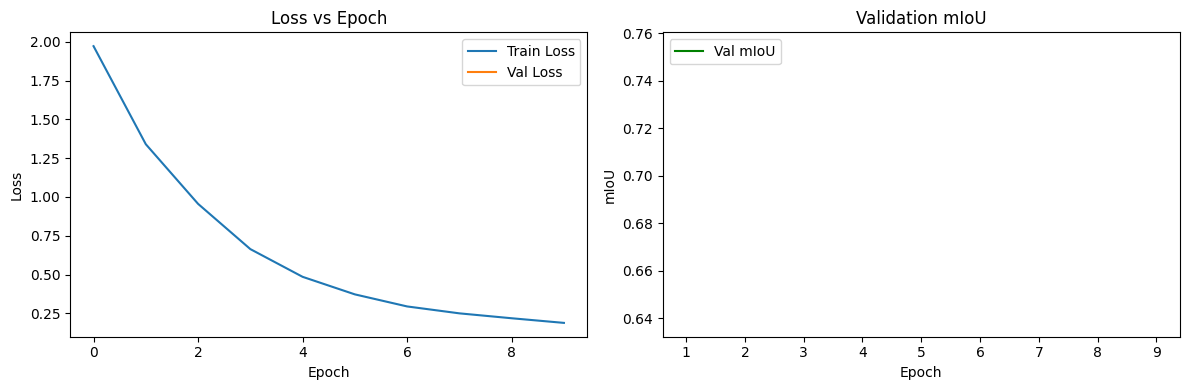

In [31]:
# Plot Loss and mIoU
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_ious, label="Val mIoU", color="green")
plt.xlabel("Epoch")
plt.ylabel("mIoU")
plt.title("Validation mIoU")
plt.legend()

plt.tight_layout()
plt.show()

In [32]:
import matplotlib.pyplot as plt

plt.figure()

# Plot train loss (has value every epoch)
plt.plot(range(num_epochs), train_losses, label='Train Loss')

# Prepare filtered val loss and x-ticks
val_epochs = [i for i, v in enumerate(val_losses) if v is not None]
val_values = [v for v in val_losses if v is not None]

plt.plot(val_epochs, val_values, label='Validation Loss', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.savefig('loss_plot.png')
plt.close()


In [ ]:
# for inferencing
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

### Inference

In [33]:
import PIL

In [ ]:

model = DinoSegModel().to(device)
model.load_state_dict(torch.load("checkpoints/best_model.pth"))
model.eval()

image_processor = AutoImageProcessor.from_pretrained("facebook/dinov2-large")
img = Image.open("path/to/image.jpg").convert("RGB")
inputs = image_processor(img, return_tensors="pt").to(device)

with torch.no_grad():
    output = model(inputs.pixel_values)
    pred = output.argmax(1).squeeze().cpu().numpy()

plt.imshow(pred, cmap='nipy_spectral')
plt.title("Prediction")
plt.show()
